<a href="https://colab.research.google.com/github/mkdib1/University_PWs/blob/main/Asseignement_2ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LIBRARIES & PACKAGES

In [1]:
import os
from google.colab import drive
import shutil
import tarfile
from matplotlib import pyplot as plt

from seaborn import boxplot
from scipy.io import wavfile as wav

from scipy.signal import spectrogram
import numpy as np
import pandas as pd

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay

import librosa
from librosa.feature import mfcc

RECORDINGS_PATH = r'/content/drive/MyDrive/audio_unzipped/recordings/'

# FUNCTIONS

The following function was built in order analyze the number of columns of either spectrogram and mel-coefficient matrices.<br>

In [2]:
# EDA function
def extract_2d_feat_columns(signal, sample_rate, spect=False, mel_coeff=False):
    """
    Compute the number of the selected 2D feature columns of a signal.
    If spect is chosen, the number of the spectrogram frames (time_blocks) is returned.
    If the mel coefficients are chosen, the number of columns in the MFCC cepstral matrix is returned,
    after applying the minimum between 2048 and the length of the signal.
    This ensures that the time window does not exceed the length of the signal.

    """
    if spect:
      _, _ , sxx = spectrogram(signal, fs=sample_rate)
      output = sxx.shape[1] # Spectrogram columns number

    if mel_coeff:
      n_fft = min(2048, len(signal))
      mfccs = mfcc(y=signal*1.0, sr=sample_rate, n_fft=n_fft)
      output = mfccs.shape[1] # MFCC columns number

    return output
def concat_2d_feat_columns(dir_path, spect=False, mel_coeff=False):
    """
    Concatenate the number of the selected 2D feature columns from each single .wav file found in dir_path.
    """
    feat_columns_ls = []
    for file in os.listdir(dir_path):
        if file.endswith(".wav"):
            try:
                file_path = os.path.join(dir_path, file)
                sample_rate, signal = wav.read(file_path)

                # Extracting number of 2d feature columns
                if spect:
                  num_columns = extract_2d_feat_columns(signal, sample_rate, spect=True)
                  feat_columns_ls.append(np.array([num_columns]))

                if mel_coeff:
                  num_columns = extract_2d_feat_columns(signal, sample_rate, mel_coeff=True)
                  feat_columns_ls.append(np.array(num_columns))

            except Exception as e:
                print(f"Error in processing {file}: {e}")

    # Return an array having concat number of 2d feature columns
    if feat_columns_ls:
        return np.array(feat_columns_ls)
    else:
        print("No .wav file has been found.")
        return np.array([])

## Spectrogram

In [3]:
def feats_spectrogram(input, tsize, rate=8000): # set fixed sample rate since it is the same for all the tracks
    _, _, spec = spectrogram(input, fs=rate)

    # zero padding if spectrogram columns are less than tsize
    if spec.shape[1] < tsize:
        spec = np.hstack((spec, np.zeros((spec.shape[0], tsize - spec.shape[1]))))

    spec = spec[:, :tsize]  # filtering the number of columns up to 'tsize' value
    output = spec.flatten() # unrolling the matrix into a 1D obj
    return output

## Mel coefficients

In [4]:
def feats_mfcc(input, tsize, rate=8000):
    n_fft = min(2048, len(input))
    mfccs = mfcc(y=input*1.0, sr=rate, n_fft=n_fft)

    # zero padding if spectrogram columns are less than tsize
    if mfccs.shape[1] < tsize:
        mfccs = np.hstack((mfccs, np.zeros((mfccs.shape[0], tsize - mfccs.shape[1]))))

    mfccs = mfccs[:, :tsize] # filtering the number of columns up to 'tsize' value
    output = mfccs.flatten() # unrolling the matrix into a 1D obj
    return output

# Dataloader

In [5]:
# Defining data loader function
def load_data(feature_extractor, tsize, normalize=False):

    # inizializing lists for saving classes and features values
    labels = []
    features = []

    directory = RECORDINGS_PATH
    for f in sorted(os.listdir(directory)): # reading .wav files from dir
        if f.endswith('.wav'):

            _, signal = wav.read(directory + f)  # saving signal into 'signal' var
            cur_features = feature_extractor(signal, tsize)
            features.append(cur_features) # appending computed feature over each array onto 'features' list


            label = f.split('_')[0]  # saving classes values
            labels.append(label)

    # Splitting observations into train and test set, 90% sv 10% size respectively
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, random_state=1)

    if normalize:
        eps = 0.001 # stabilizer param
        X_train = np.array(X_train)
        X_train_mean = X_train.mean(axis=0)
        X_train_std = X_train.std(axis=0)
        X_train = (X_train - X_train_mean + eps)/(X_train_std + eps) # normailzing values aroung train set mean and std
        X_train = [row for row in X_train]
        X_test = [row for row in (np.array(X_test) - X_train_mean + eps)/(X_train_std + eps)] # using mean and std to normalize test set too

    return X_train, X_test, y_train, y_test

## Confusion matrix builder

In [6]:
def plot_confusion_matrix(y_true, y_pred):

    cm = confusion_matrix(y_true, y_pred) # building the confusion matrix

    # Display settings
    y_true_labels = np.unique(y_true)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_true_labels)
    disp.plot(cmap='Blues', values_format='d')

    # Graph settings
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

## Model fitter & evaluator


In [7]:
def train_and_evaluate_svm_with_graphs(feature_extractor, tsize, normalize=False, kernel='rbf', class_weight='balanced'):

    X_train, X_test, y_train, y_test = load_data(feature_extractor, tsize, normalize=normalize) # loading data choosing custom feature extractor

    svm_clsf = None
    svm_clsf = SVC(kernel=kernel, class_weight=class_weight) # model definition
    svm_clsf.fit(X_train, y_train) # training the model (Support vector machine)

    y_pred = svm_clsf.predict(X_test) # computing test_set prediction
    acc = round(accuracy_score(y_test, y_pred),2) # computing model accuracy
    print("---"*10)
    print("accuracy score: ", acc) # printing the accuracy
    print("---"*10)

    # Building confusion matrix through defining visual settings
    plot_confusion_matrix(y_test, y_pred)

    return X_train, X_test, y_train, y_test, y_pred, acc

# MAIN

Activate comment lines if needed to extract file from zip folder

In [8]:
drive.mount('/content/drive')
# tar_path = '/content/drive/MyDrive/recordings.tar'

Mounted at /content/drive


In [9]:
# with tarfile.open(tar_path, 'r') as tar_ref:
#     tar_ref.extractall('/content/drive/MyDrive/audio_unzipped')

In [10]:
# shutil.rmtree('/content/drive/MyDrive/audio_unzipped')

## EDA

The selection of the number of columns for the spectrogram and the mel-coefficient matrix to be used as 2D features for the SVM classifier was based on heuristic reasoning following an Exploratory Data Analysis (EDA), in which the distribution of the size of the dimension of interest has been examined.

The following approach has been addressed:

* initially, the **minimum** number of columns among the matrices extracted from the dataset folder was selected;
* a classification model was built, and its performance was evaluated;
* this process was repeated using the **median** and **maximum** values, respectively.
Differently from the first case, matrices with a lower number of columns than the target number were handled by applying **zero-padding**, adding the required number of columns to fit the *tsize* parameter, with the added values set to 0.

The analysis was initially conducted using the spectrogram as the 2D feature, which led to selecting the median value as the optimal choice for the tsize parameter.

Although the minimum, maximum, and median values were also extracted for the mel-coefficient matrices, the results of the EDA conducted on the spectrograms directly led to the decision to use the **median** value for the extraction of MFCCs.

Satisfactory performance which was achieved when using the **median** column numbers in mel-coefficients *tsize* param as classifier features did not require further tuning with different tsize values.

### Spectrogram number of columns

In [11]:
time_blocks = concat_2d_feat_columns(RECORDINGS_PATH, spect=True)

Let's visualize the distribution of the spectrogram columns number using a boxplot, to better understand measures such as median, IQR and the presence of any outliers

<Axes: >

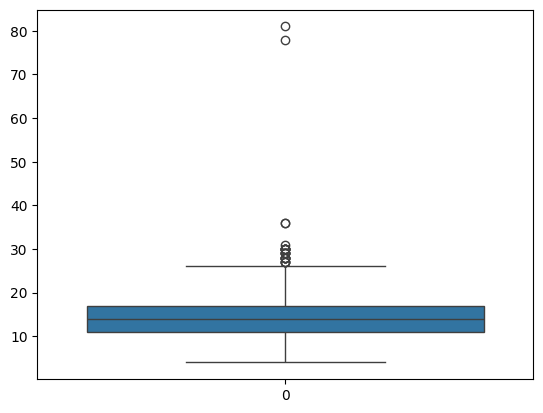

In [12]:
boxplot(time_blocks)

In [13]:
print("Median of spectrogram columns number: ",int(np.median(time_blocks)))
print("Minimum of spectrogram columns number: ",np.min(time_blocks))
print("Maximum of spectrogram columns number: ",np.max(time_blocks))

Median of spectrogram columns number:  14
Minimum of spectrogram columns number:  4
Maximum of spectrogram columns number:  81


As it can be noticed, the distribution of values seems to be quite symmetric around the median, although there is a slight right-tailed skewness caused by the presence of some outliers.

### Mel-coefficient number of columns

The same analysis has been done by considering the number of columns of mel-coefficient matrices

In [14]:
mfcc_cols = concat_2d_feat_columns(RECORDINGS_PATH, mel_coeff=True)

<Axes: >

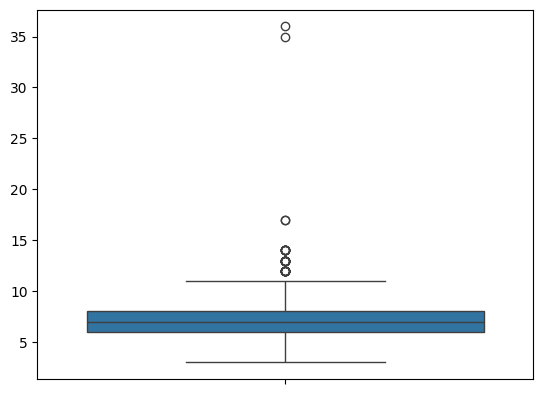

In [15]:
boxplot(mfcc_cols)

In [16]:
print("Median of spectrogram columns number: ",int(np.median(mfcc_cols)))
print("Minimum of spectrogram columns number: ",np.min(mfcc_cols))
print("Maximum of spectrogram columns number: ",np.max(mfcc_cols))

Median of spectrogram columns number:  7
Minimum of spectrogram columns number:  3
Maximum of spectrogram columns number:  36


The same considerations which have been made previously can be replicated, even though the right-skeweness is much less noticeable.

## SVM application with **spectrogram** as 2D feature

#### Tsize = minimum spectrogram columns

------------------------------
accuracy score:  0.39
------------------------------


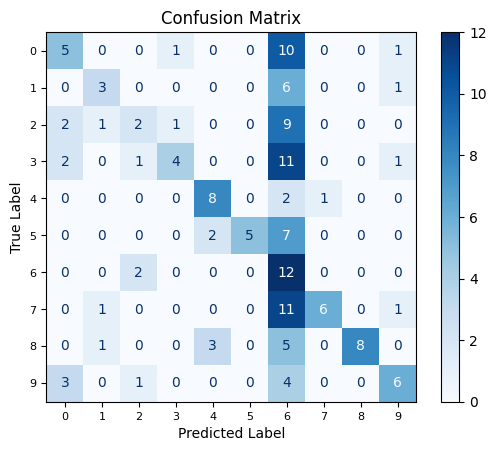

In [17]:
X_train_1a, X_test_1a, y_train_1a, y_test_1a, y_pred_1a, acc_1a = train_and_evaluate_svm_with_graphs(feature_extractor=feats_spectrogram, tsize=4)

In [18]:
print(classification_report(y_test_1a, y_pred_1a))

              precision    recall  f1-score   support

           0       0.42      0.29      0.34        17
           1       0.50      0.30      0.38        10
           2       0.33      0.13      0.19        15
           3       0.67      0.21      0.32        19
           4       0.62      0.73      0.67        11
           5       1.00      0.36      0.53        14
           6       0.16      0.86      0.26        14
           7       0.86      0.32      0.46        19
           8       1.00      0.47      0.64        17
           9       0.60      0.43      0.50        14

    accuracy                           0.39       150
   macro avg       0.61      0.41      0.43       150
weighted avg       0.63      0.39      0.42       150



##### `feats_spectrogram`, normalize=True

------------------------------
accuracy score:  0.49
------------------------------


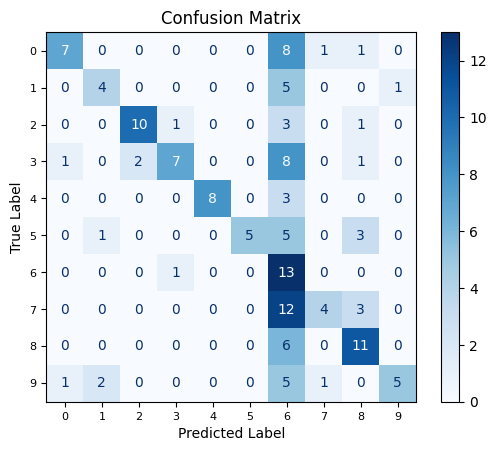

In [19]:
X_train_1b, X_test_1b, y_train_1b, y_test_1b, y_pred_1b, acc_1b = train_and_evaluate_svm_with_graphs(feature_extractor=feats_spectrogram, tsize=4, normalize=True)

In [20]:
print(classification_report(y_test_1b, y_pred_1b))

              precision    recall  f1-score   support

           0       0.78      0.41      0.54        17
           1       0.57      0.40      0.47        10
           2       0.83      0.67      0.74        15
           3       0.78      0.37      0.50        19
           4       1.00      0.73      0.84        11
           5       1.00      0.36      0.53        14
           6       0.19      0.93      0.32        14
           7       0.67      0.21      0.32        19
           8       0.55      0.65      0.59        17
           9       0.83      0.36      0.50        14

    accuracy                           0.49       150
   macro avg       0.72      0.51      0.53       150
weighted avg       0.72      0.49      0.52       150



#### Tsize = median spectrogram columns

------------------------------
accuracy score:  0.45
------------------------------


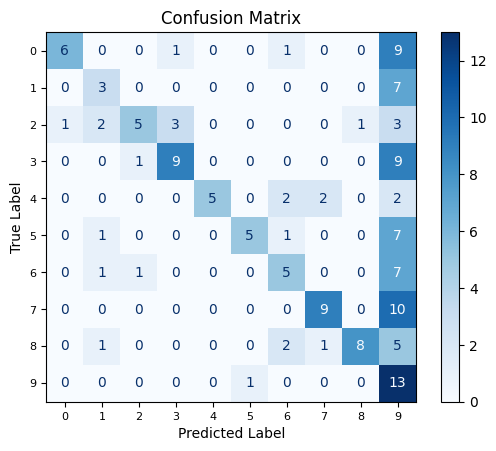

In [21]:
X_train_2a, X_test_2a, y_train_2a, y_test_2a, y_pred_2a, acc_2a = train_and_evaluate_svm_with_graphs(feature_extractor=feats_spectrogram, tsize=14)

In [22]:
print(classification_report(y_test_2a, y_pred_2a))

              precision    recall  f1-score   support

           0       0.86      0.35      0.50        17
           1       0.38      0.30      0.33        10
           2       0.71      0.33      0.45        15
           3       0.69      0.47      0.56        19
           4       1.00      0.45      0.62        11
           5       0.83      0.36      0.50        14
           6       0.45      0.36      0.40        14
           7       0.75      0.47      0.58        19
           8       0.89      0.47      0.62        17
           9       0.18      0.93      0.30        14

    accuracy                           0.45       150
   macro avg       0.67      0.45      0.49       150
weighted avg       0.69      0.45      0.50       150



##### `feats_spectrogram`, normalize=True

------------------------------
accuracy score:  0.5
------------------------------


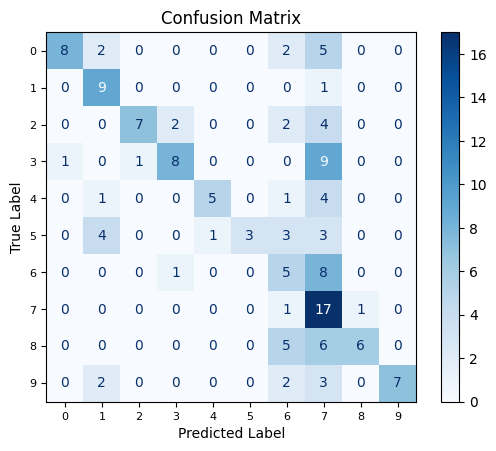

In [23]:
X_train_2b, X_test_2b, y_train_2b, y_test_2b, y_pred_2b, acc_2b = train_and_evaluate_svm_with_graphs(feature_extractor=feats_spectrogram, tsize=14,normalize=True)

In [24]:
print(classification_report(y_test_2b, y_pred_2b))

              precision    recall  f1-score   support

           0       0.89      0.47      0.62        17
           1       0.50      0.90      0.64        10
           2       0.88      0.47      0.61        15
           3       0.73      0.42      0.53        19
           4       0.83      0.45      0.59        11
           5       1.00      0.21      0.35        14
           6       0.24      0.36      0.29        14
           7       0.28      0.89      0.43        19
           8       0.86      0.35      0.50        17
           9       1.00      0.50      0.67        14

    accuracy                           0.50       150
   macro avg       0.72      0.50      0.52       150
weighted avg       0.72      0.50      0.52       150



#### Tsize = maximum spectrogram columns

------------------------------
accuracy score:  0.44
------------------------------


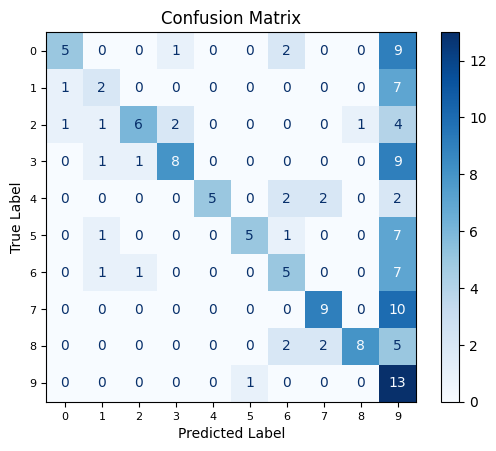

In [25]:
X_train_3a, X_test_3a, y_train_3a, y_test_3a, y_pred_3a, acc_3a = train_and_evaluate_svm_with_graphs(feature_extractor=feats_spectrogram, tsize=81)

In [26]:
print(classification_report(y_test_3a, y_pred_3a))

              precision    recall  f1-score   support

           0       0.71      0.29      0.42        17
           1       0.33      0.20      0.25        10
           2       0.75      0.40      0.52        15
           3       0.73      0.42      0.53        19
           4       1.00      0.45      0.62        11
           5       0.83      0.36      0.50        14
           6       0.42      0.36      0.38        14
           7       0.69      0.47      0.56        19
           8       0.89      0.47      0.62        17
           9       0.18      0.93      0.30        14

    accuracy                           0.44       150
   macro avg       0.65      0.44      0.47       150
weighted avg       0.67      0.44      0.48       150



##### `feats_spectrogram`, normalize=True

------------------------------
accuracy score:  0.43
------------------------------


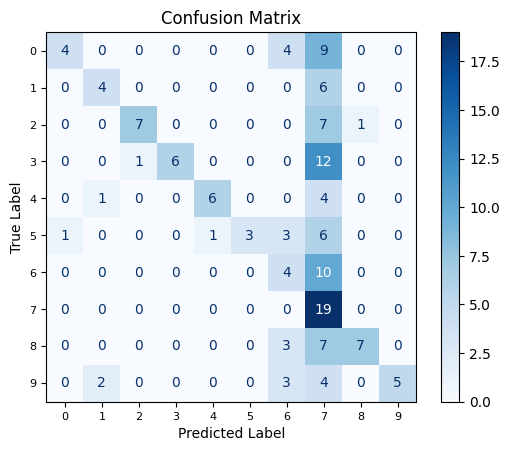

In [27]:
X_train_3b, X_test_3b, y_train_3b, y_test_3b, y_pred_3b, acc_3b = train_and_evaluate_svm_with_graphs(feature_extractor=feats_spectrogram, tsize=81, normalize=True)

In [28]:
print(classification_report(y_test_3b, y_pred_3b))

              precision    recall  f1-score   support

           0       0.80      0.24      0.36        17
           1       0.57      0.40      0.47        10
           2       0.88      0.47      0.61        15
           3       1.00      0.32      0.48        19
           4       0.86      0.55      0.67        11
           5       1.00      0.21      0.35        14
           6       0.24      0.29      0.26        14
           7       0.23      1.00      0.37        19
           8       0.88      0.41      0.56        17
           9       1.00      0.36      0.53        14

    accuracy                           0.43       150
   macro avg       0.74      0.42      0.47       150
weighted avg       0.74      0.43      0.46       150



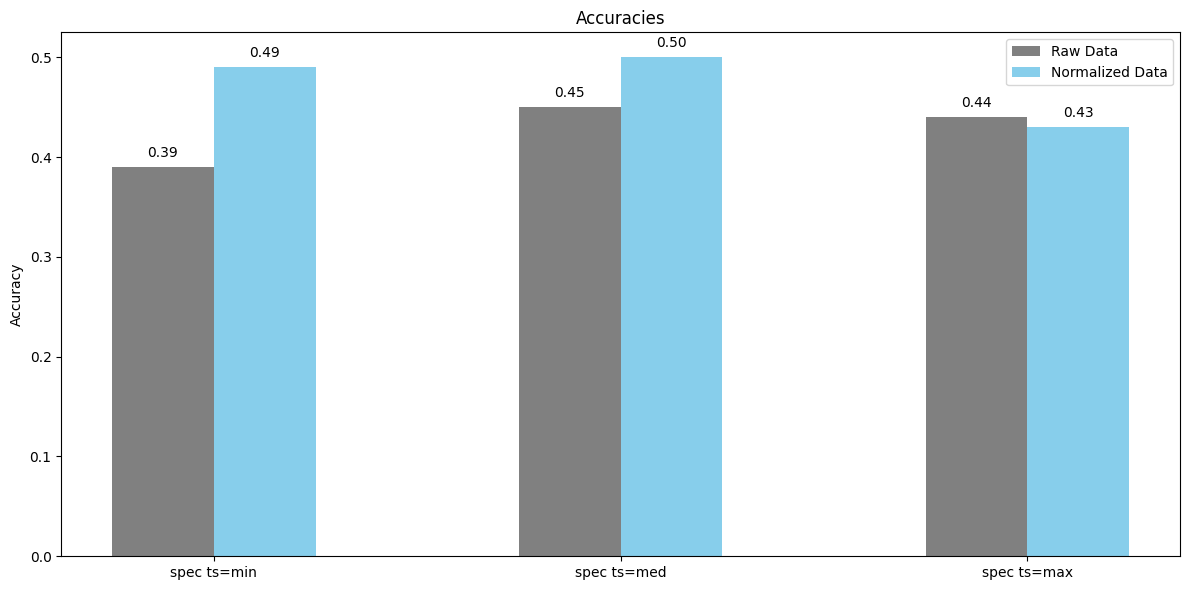

In [29]:
model_names = ['spec ts=min\nraw data', 'spec ts=min\nnorm data',
               'spec ts=med\nraw data', 'spec ts=med\nnorm data',
               'spec ts=max\nraw data', 'spec ts=max\nnorm data']

accuracies = [acc_1a, acc_1b, acc_2a, acc_2b, acc_3a, acc_3b]

colors = ['gray', 'skyblue'] * (len(model_names) // 2)

x_indices = np.arange(0, len(model_names) // 2)
bar_width = 0.25

plt.figure(figsize=(12, 6))

for i in range(len(x_indices)):
    plt.bar(x_indices[i] - bar_width / 2, accuracies[2 * i], color='gray', width=bar_width, label='Raw Data' if i == 0 else "")
    plt.bar(x_indices[i] + bar_width / 2, accuracies[2 * i + 1], color='skyblue', width=bar_width, label='Normalized Data' if i == 0 else "")

plt.xticks(x_indices, ['spec ts=min', 'spec ts=med', 'spec ts=max'])

for i, acc in enumerate(accuracies):
    x_pos = (x_indices[i // 2] - bar_width / 2) if i % 2 == 0 else (x_indices[i // 2] + bar_width / 2)
    plt.text(x_pos, acc + 0.01, f'{acc:.2f}', ha='center', fontsize=10)

plt.ylabel('Accuracy')
plt.title('Accuracies')
plt.legend()
plt.tight_layout()

plt.show()

By plotting the accuracy scores achieved using spectrograms with different 'tsize' values (both for raw and normalized data), the following observations can be made:

* for the **min** value of 'tsize', a larger gap was observed between the performance of normalized data and raw data.
* the **median** value of 'tsize' resulted in the highest accuracy score when using normalized data, though a performance difference still persists compared to the raw data model.
* for the **max** value of 'tsize', the lowest accuracy was observed with normalized data. This is likely due to the fact that this value acts as an outlier (as seen in the EDA section), leading to the creation of many zero-padded columns in the 2D matrices.

## SVM application with **mel-coefficients** as 2D feature

------------------------------
accuracy score:  0.73
------------------------------


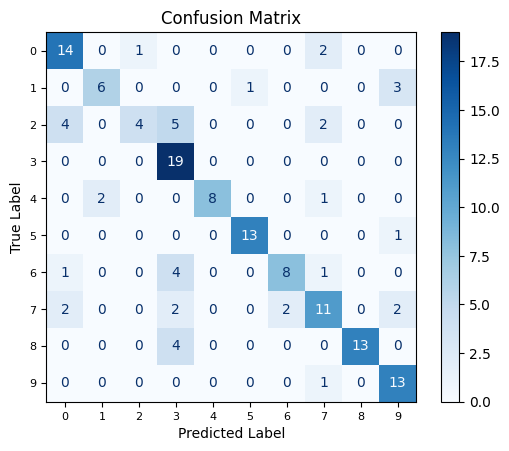

In [30]:
X_train_4a, X_test_4a, y_train_4a, y_test_4a, y_pred_4a, acc_4a = train_and_evaluate_svm_with_graphs(feature_extractor=feats_mfcc, tsize=7)

In [31]:
print(classification_report(y_test_4a, y_pred_4a))

              precision    recall  f1-score   support

           0       0.67      0.82      0.74        17
           1       0.75      0.60      0.67        10
           2       0.80      0.27      0.40        15
           3       0.56      1.00      0.72        19
           4       1.00      0.73      0.84        11
           5       0.93      0.93      0.93        14
           6       0.80      0.57      0.67        14
           7       0.61      0.58      0.59        19
           8       1.00      0.76      0.87        17
           9       0.68      0.93      0.79        14

    accuracy                           0.73       150
   macro avg       0.78      0.72      0.72       150
weighted avg       0.77      0.73      0.72       150



#### `feats_mfcc`, normalize=True

------------------------------
accuracy score:  0.99
------------------------------


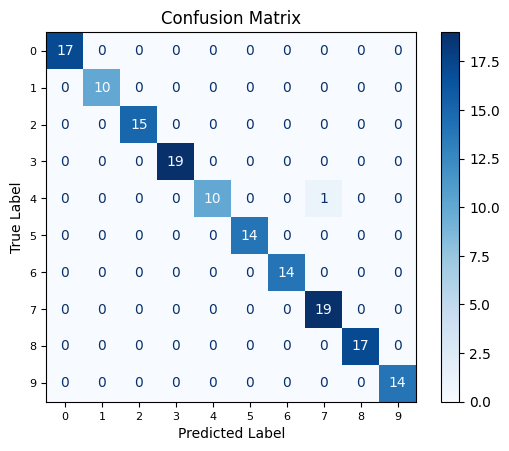

In [32]:
X_train_4b, X_test_4b, y_train_4b, y_test_4b, y_pred_4b, acc_4b = train_and_evaluate_svm_with_graphs(feature_extractor=feats_mfcc, tsize=7, normalize=True)

In [33]:
print(classification_report(y_test_4b, y_pred_4b))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        15
           3       1.00      1.00      1.00        19
           4       1.00      0.91      0.95        11
           5       1.00      1.00      1.00        14
           6       1.00      1.00      1.00        14
           7       0.95      1.00      0.97        19
           8       1.00      1.00      1.00        17
           9       1.00      1.00      1.00        14

    accuracy                           0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150



It can be observed that **mfcc** demonstrates to be an effective 2D feature for classification, as the performance improves from an initial raw accuracy score of *0.73* to *0.99* after applying normalization to the data.<br>
Such a result is typically considered an outstanding score in machine learning model training.

# Hyperparameter tuning

In order to choose the optimal values for the SVC parameters, namely C and gamma, a grid search was performed starting from predefined values used for tuning.<br>

The process was conducted using the spectrogram as 2D feature only, specifically with the 'tsize' parameter value that previously led to the optimal results.<br>

The performance achieved using **mfcc** did not require any hyperparameter optimization; therefore, no tuning was performed in this case."

In [34]:
# Grid definition
clf_gs = None
param_grid = {'C': [100, 500, 1000],
              'gamma': [0.05, 0.5, 0.1, 0.01, 0.005]}

# Grid search with cross validation set to 10
clf_gs = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=10)
clf_gs.fit(X_train_2b, y_train_2b)

GridSearchCV(cv=10, estimator=SVC(class_weight='balanced'),
             param_grid={'C': [100, 500, 1000],
                         'gamma': [0.05, 0.5, 0.1, 0.01, 0.005]})

In [35]:
print("Best C hyperparam: ",clf_gs.best_estimator_.C)
print("Best gamma hyperparam: ",clf_gs.best_estimator_.gamma)

Best C hyperparam:  1000
Best gamma hyperparam:  0.005


Let's see the performance

In [36]:
y_pred_gs = clf_gs.predict(X_test_2b)
print(classification_report(y_test_2b, y_pred_gs))

              precision    recall  f1-score   support

           0       0.83      0.59      0.69        17
           1       0.64      0.70      0.67        10
           2       0.77      0.67      0.71        15
           3       0.83      0.53      0.65        19
           4       0.17      0.73      0.28        11
           5       0.71      0.71      0.71        14
           6       0.30      0.43      0.35        14
           7       0.67      0.32      0.43        19
           8       1.00      0.24      0.38        17
           9       0.62      0.36      0.45        14

    accuracy                           0.51       150
   macro avg       0.65      0.53      0.53       150
weighted avg       0.68      0.51      0.54       150



Even though a hyperparameter optimization procedure was performed, accuracy does not seem to gain from it, as its score increased only marginally from 0.50 to 0.51.<br>

These results confirm that **mfcc** proves to be a better feature for training the classifier.